# 06_evaluation_compare.ipynb

**Project-wide evaluation and comparison** for:
- Baseline CNN
- Transfer Learning CNN (MobileNetV2 / ResNet50)
- CNN-LSTM (sequence)
- EfficientNet or ViT

This notebook will:
1. Load your test set from `data/processed/`
2. Locate latest saved models/reports in `models/` and `results/`
3. Evaluate each available model (fallback: parse its saved text report)
4. Build a comparison table (Accuracy, Precision, Recall, F1)
5. Plot accuracy bars and save `results/summary.csv`


In [3]:
import os, re, glob, json, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import load_model

# Paths
PROCESSED_DIR = "../data/processed"
MODEL_DIR     = "models"
RESULTS_DIR   = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

CLASS_NAMES = ["Closed_Eyes","Open_Eyes","Yawn","No_Yawn"]
num_classes = len(CLASS_NAMES)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [4]:
# Load test arrays (frames). For CNN-LSTM we will synthesize short sequences if needed.
X_test  = np.load(f"{PROCESSED_DIR}/X_test.npy")
y_test  = np.load(f"{PROCESSED_DIR}/y_test.npy")
print("Test shape:", X_test.shape, "Labels:", y_test.shape)


Test shape: (245, 64, 64, 3) Labels: (245,)


In [6]:
def latest_file(pattern):
    files = glob.glob(pattern)
    if not files:
        return None
    files.sort(key=os.path.getmtime, reverse=True)
    return files[0]

def safe_load_model(path):
    try:
        return load_model(path)
    except Exception as e:
        print(f"[WARN] Could not load model: {path}\n{e}")
        return None

def parse_report_txt(path):
    # Try to parse accuracy from saved report text (first line format: "Test accuracy: 0.9345")
    if not path or not os.path.exists(path):
        return None
    acc = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if "Test accuracy:" in line:
                try:
                    acc = float(line.strip().split(":")[1])
                except:
                    pass
                break
    return {"accuracy": acc}


In [7]:
from sklearn.metrics import classification_report

def eval_frame_model(model, X_test, y_test):
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    return {"accuracy": acc, "precision_macro": p, "recall_macro": r, "f1_macro": f1, "cm": cm}


In [8]:
from collections import defaultdict, Counter

def index_by_class(y):
    buckets = defaultdict(list)
    for idx, label in enumerate(y):
        buckets[int(label)].append(idx)
    return buckets

def build_sequences_from_frames(X, y, T=8, per_class=120):
    buckets = index_by_class(y)
    X_seqs, y_seqs = [], []
    for cls, idxs in buckets.items():
        idxs = np.array(idxs)
        n_avail = len(idxs)
        n_make = min(per_class, max(1, n_avail // max(1, T//2)))
        for _ in range(n_make):
            chosen = np.random.choice(idxs, size=T, replace=True)
            seq = X[chosen]
            X_seqs.append(seq); y_seqs.append(cls)
    return np.array(X_seqs), np.array(y_seqs)

def eval_seq_model(model, X_frames, y_frames, T=8, per_class=120):
    Xs, ys = build_sequences_from_frames(X_frames, y_frames, T=T, per_class=per_class)
    y_prob = model.predict(Xs, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    acc = accuracy_score(ys, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(ys, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(ys, y_pred)
    return {"accuracy": acc, "precision_macro": p, "recall_macro": r, "f1_macro": f1, "cm": cm}


In [9]:
candidates = {
    "baseline_cnn": {
        "model": latest_file(f"{MODEL_DIR}/baseline_cnn_final_*.keras"),
        "report": latest_file(f"{RESULTS_DIR}/baseline_cnn_report_*.txt"),
        "type": "frame"
    },
    "transfer": {
        "model": latest_file(f"{MODEL_DIR}/transfer_*_final_*.keras"),
        "report": latest_file(f"{RESULTS_DIR}/transfer_*_report_*.txt"),
        "type": "frame"
    },
    "cnn_lstm": {
        "model": latest_file(f"{MODEL_DIR}/cnn_lstm_final_*.keras"),
        "report": latest_file(f"{RESULTS_DIR}/cnn_lstm_report_*.txt"),
        "type": "sequence"
    },
    "efficientnet_or_vit": {
        "model": latest_file(f"{MODEL_DIR}/*(efficientnet|vit)*_final_*.keras"),  # glob can't do regex; handle below
        "report": None,
        "type": "frame"
    }
}

# Fix the efficientnet/vit pattern by manual search
eff = latest_file(f"{MODEL_DIR}/efficientnet_final_*.keras")
vit = latest_file(f"{MODEL_DIR}/vit_final_*.keras")
candidates["efficientnet_or_vit"]["model"]  = eff if eff else vit
candidates["efficientnet_or_vit"]["report"] = latest_file(f"{RESULTS_DIR}/efficientnet_report_*.txt") or latest_file(f"{RESULTS_DIR}/vit_report_*.txt")

candidates


{'baseline_cnn': {'model': 'models\\baseline_cnn_final_20251011-173237.keras',
  'report': 'results\\baseline_cnn_report_20251011-173237.txt',
  'type': 'frame'},
 'transfer': {'model': 'models\\transfer_mobilenetv2_final_20251011-174106_mobilenetv2.keras',
  'report': 'results\\transfer_mobilenetv2_report_20251011-174106_mobilenetv2.txt',
  'type': 'frame'},
 'cnn_lstm': {'model': 'models\\cnn_lstm_final_20251011-180143_cnnlstm.keras',
  'report': 'results\\cnn_lstm_report_20251011-180143_cnnlstm.txt',
  'type': 'sequence'},
 'efficientnet_or_vit': {'model': None, 'report': None, 'type': 'frame'}}

In [10]:
summary_rows = []
all_cms = {}

for name, spec in candidates.items():
    model_path = spec["model"]
    report_path = spec["report"]
    mtype = spec["type"]
    print(f"\n=== {name.upper()} ===")
    print("model:", model_path)
    print("report:", report_path)

    metrics = None
    if model_path and os.path.exists(model_path):
        model = safe_load_model(model_path)
        if model is not None:
            try:
                if mtype == "frame":
                    metrics = eval_frame_model(model, X_test, y_test)
                else:
                    metrics = eval_seq_model(model, X_test, y_test, T=8, per_class=120)
            except Exception as e:
                print("[WARN] Evaluation failed, will try parsing report:", e)

    # Fallback to report parsing
    if metrics is None and report_path:
        pr = parse_report_txt(report_path)
        if pr and pr.get("accuracy") is not None:
            metrics = {"accuracy": pr["accuracy"], "precision_macro": None, "recall_macro": None, "f1_macro": None, "cm": None}

    if metrics is None:
        print("No metrics available for", name)
        continue

    row = {
        "Model": name,
        "Accuracy": float(metrics["accuracy"]),
        "Precision(macro)": float(metrics["precision_macro"]) if metrics["precision_macro"] is not None else np.nan,
        "Recall(macro)": float(metrics["recall_macro"]) if metrics["recall_macro"] is not None else np.nan,
        "F1(macro)": float(metrics["f1_macro"]) if metrics["f1_macro"] is not None else np.nan
    }
    summary_rows.append(row)
    if metrics["cm"] is not None:
        all_cms[name] = metrics["cm"]

import pandas as pd
df = pd.DataFrame(summary_rows).sort_values("Accuracy", ascending=False)
df



=== BASELINE_CNN ===
model: models\baseline_cnn_final_20251011-173237.keras
report: results\baseline_cnn_report_20251011-173237.txt

=== TRANSFER ===
model: models\transfer_mobilenetv2_final_20251011-174106_mobilenetv2.keras
report: results\transfer_mobilenetv2_report_20251011-174106_mobilenetv2.txt
[WARN] Could not load model: models\transfer_mobilenetv2_final_20251011-174106_mobilenetv2.keras
<class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999974752427e-07, 'weight_decay': None

,Model,Accuracy,Precision(macro),Recall(macro),F1(macro)
2,cnn_lstm,0.916667,0.921027,0.916667,0.916351
0,baseline_cnn,0.844898,0.855390,0.845915,0.843952
1,transfer,0.546900,NaN,NaN,NaN


In [ ]:
from caas_jupyter_tools import display_dataframe_to_user
display_dataframe_to_user("Model Comparison Summary", df)
csv_path = f"{RESULTS_DIR}/summary.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)


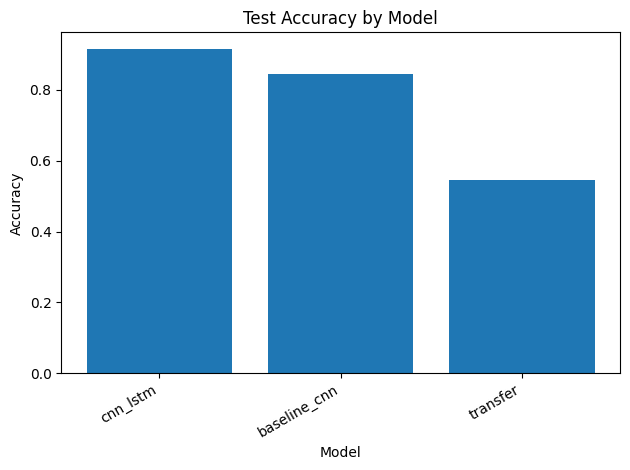

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(df["Model"], df["Accuracy"])
plt.title("Test Accuracy by Model")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


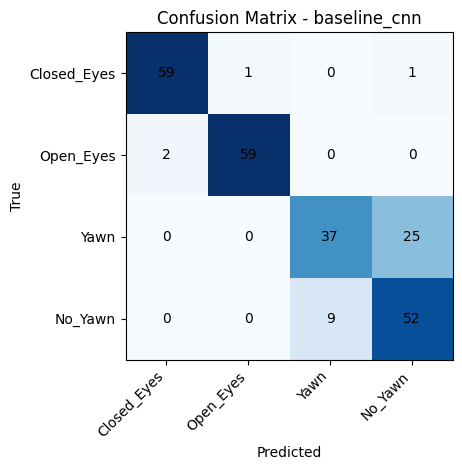

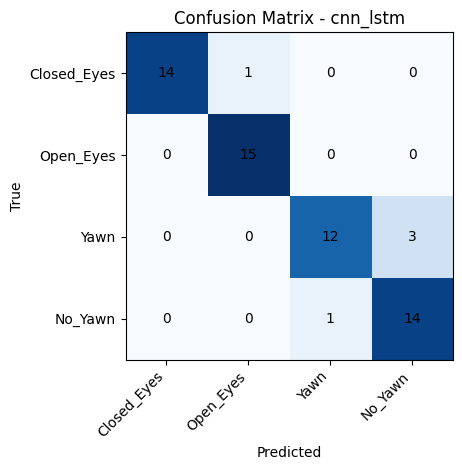

In [13]:
for name, cm in all_cms.items():
    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(num_classes), CLASS_NAMES, rotation=45, ha="right")
    plt.yticks(range(num_classes), CLASS_NAMES)
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()
